In [1]:
import json
import sys
import glob
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

In [2]:
DIR = "/home/claudio/hdd/git/bachelorThesis/figure_9/"

In [15]:
def categorical_plot(df, key, title, sorted_xs = None):
    if sorted_xs == None:
        xs = set()
        lines = []
        for t in [4,5,6,7,8]:
            xs = xs.union(np.array(df[df.term == t][key]).reshape(-1))
        xs = [str(x) for x in sorted(xs)]
    else:
        xs = sorted_xs
        
    plt.figure(figsize=(25,8))
    ax = plt.gca()
    lines = []
    for t in [4,5,6,7,8]:
        ys = []
        for x in xs:
            partsum = df[(df.term != -1) & (df[key] == x)]["count"].sum().astype(int)
            y = df[(df.term == t) & (df[key] == x)]["count"]
            ys.append((y.values.astype(int)[0] / partsum if partsum > 0 else y.values.astype(int)[0]) if y.any() else 0)
        lines.append(ax.plot(xs,ys, marker='.')[0])

    plt.xticks(xs)
    plt.legend(lines, ["EVICT", "FAIL", "FINISH", "KILL", "LOST"],
              bbox_to_anchor=(1,1))
    plt.title(title)
    plt.show()

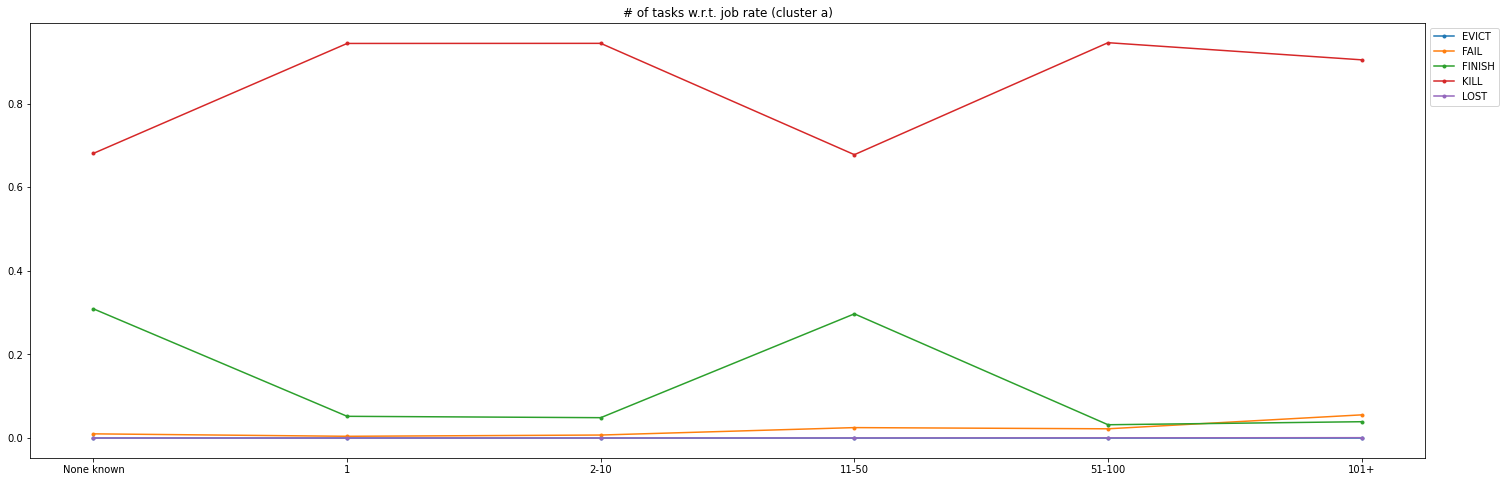

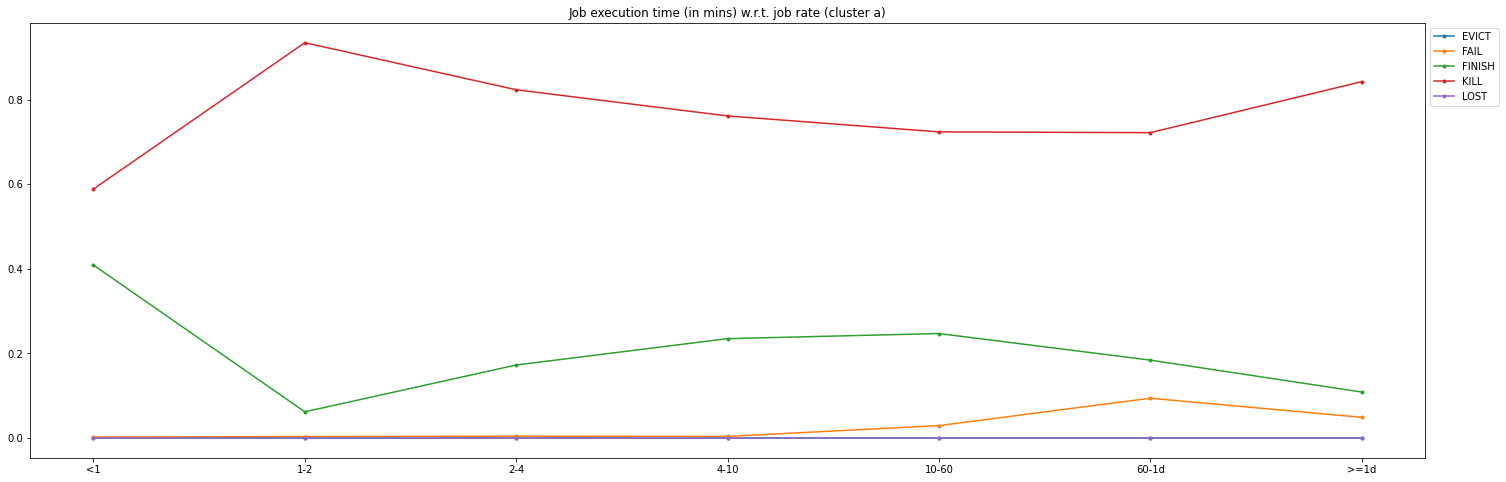

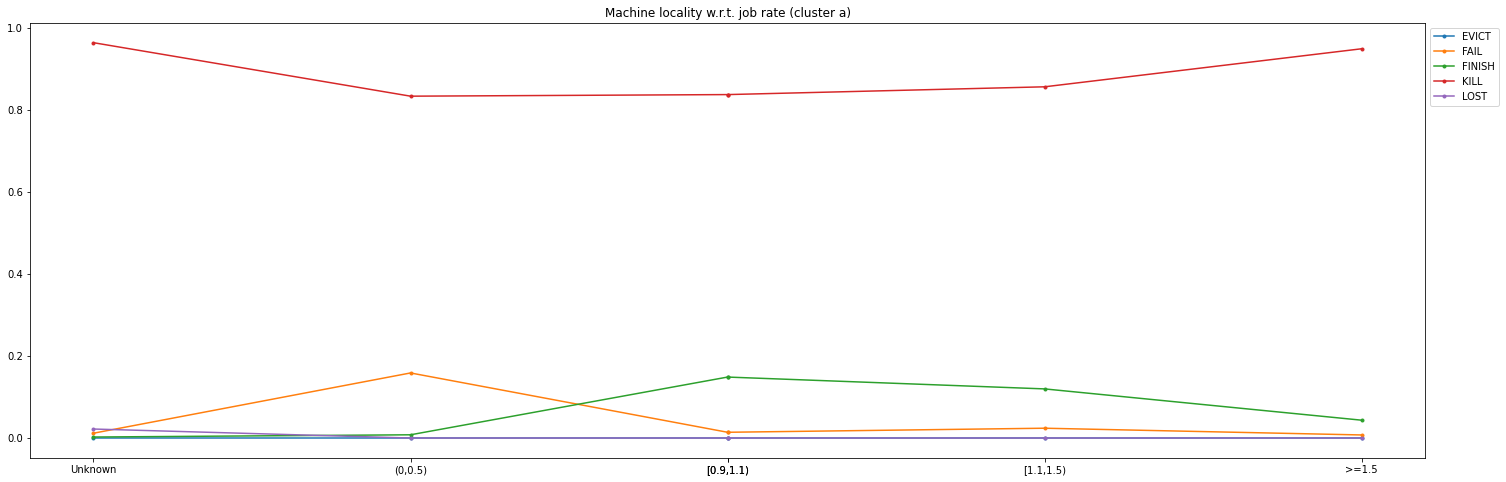

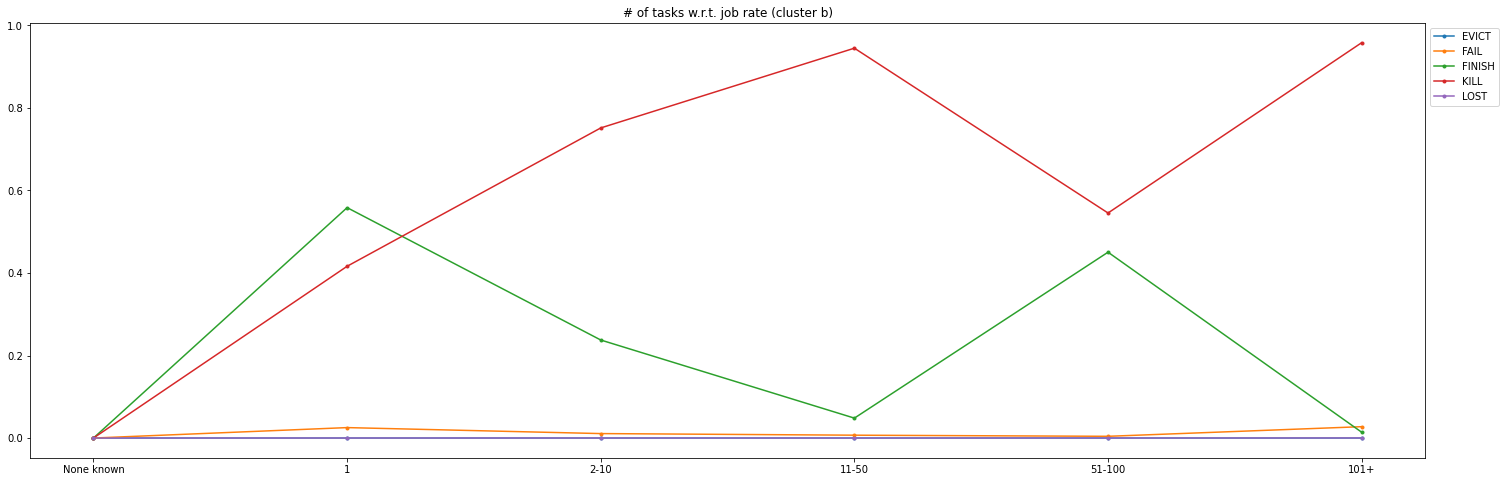

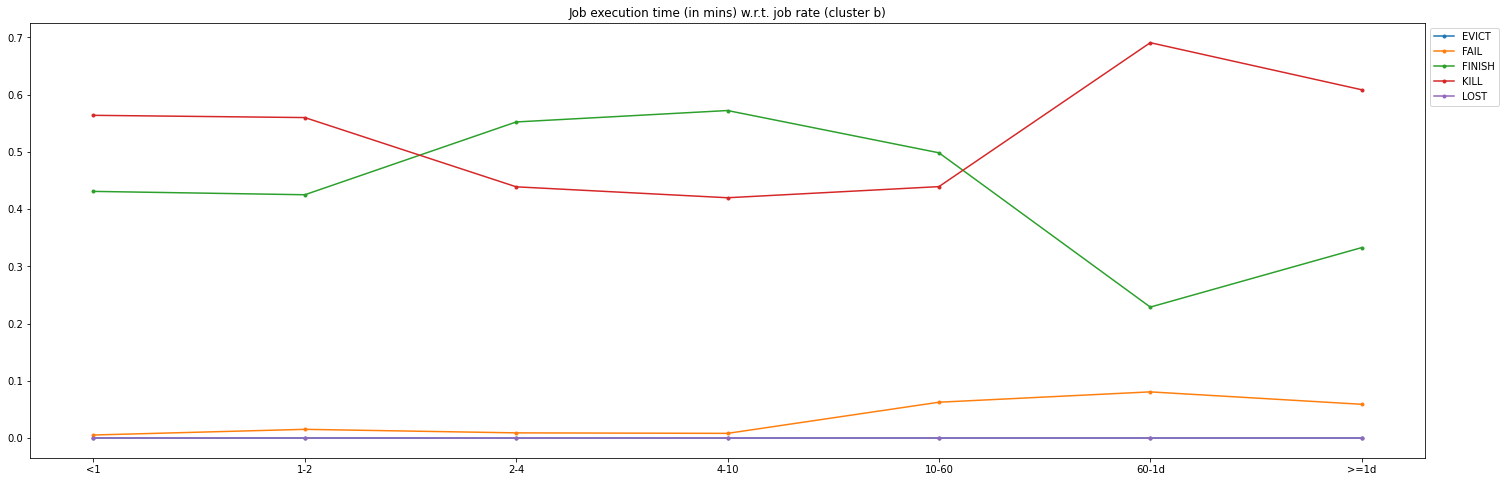

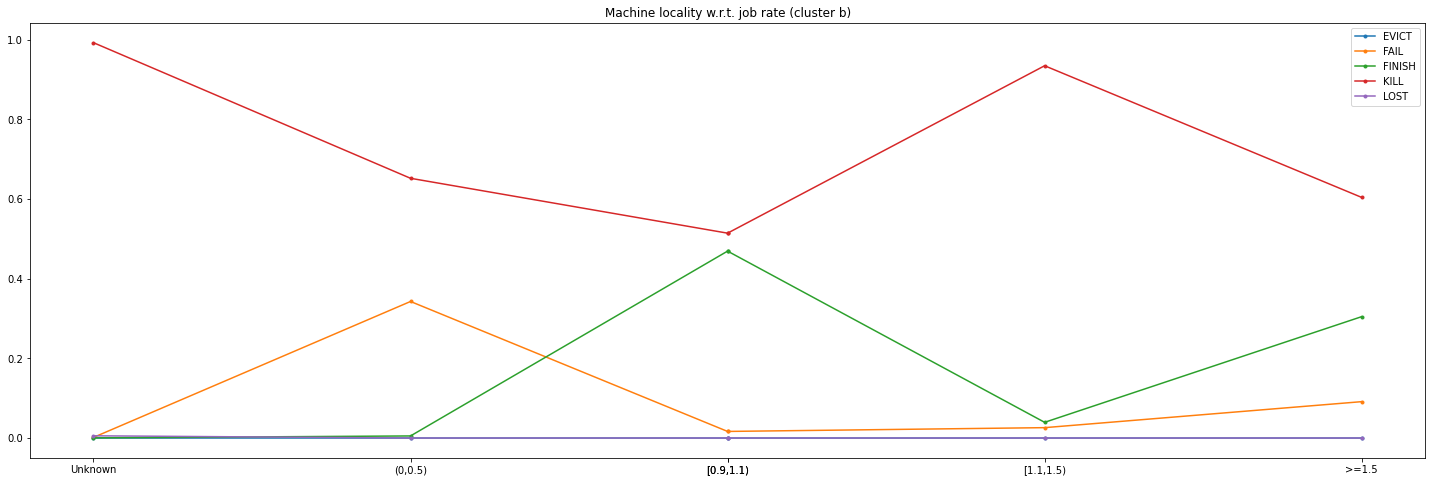

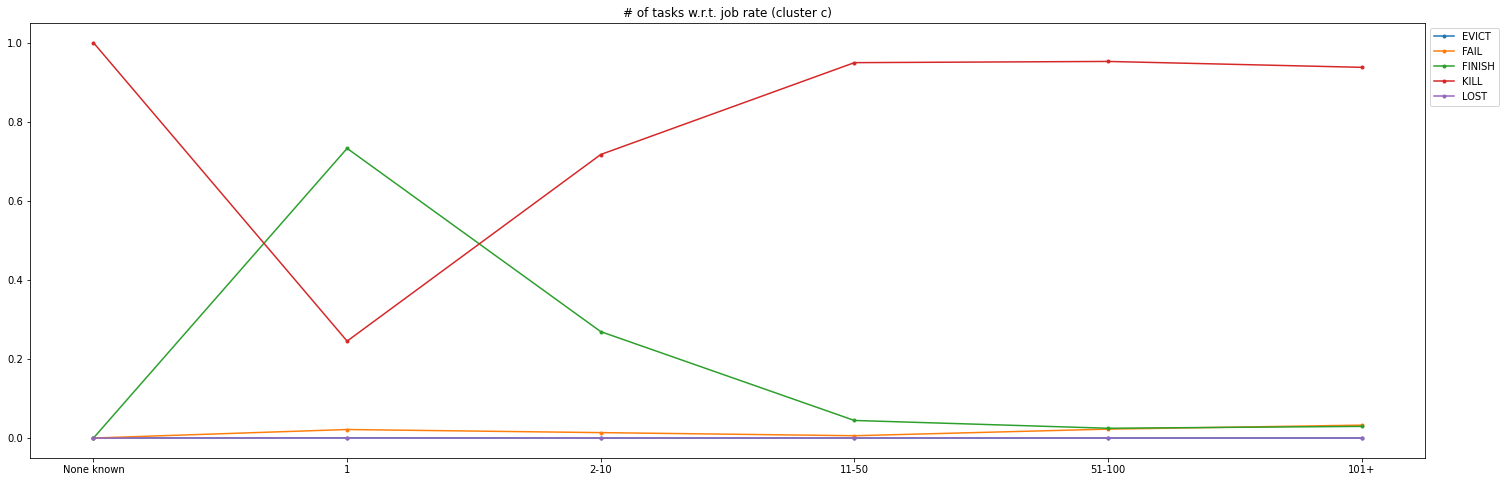

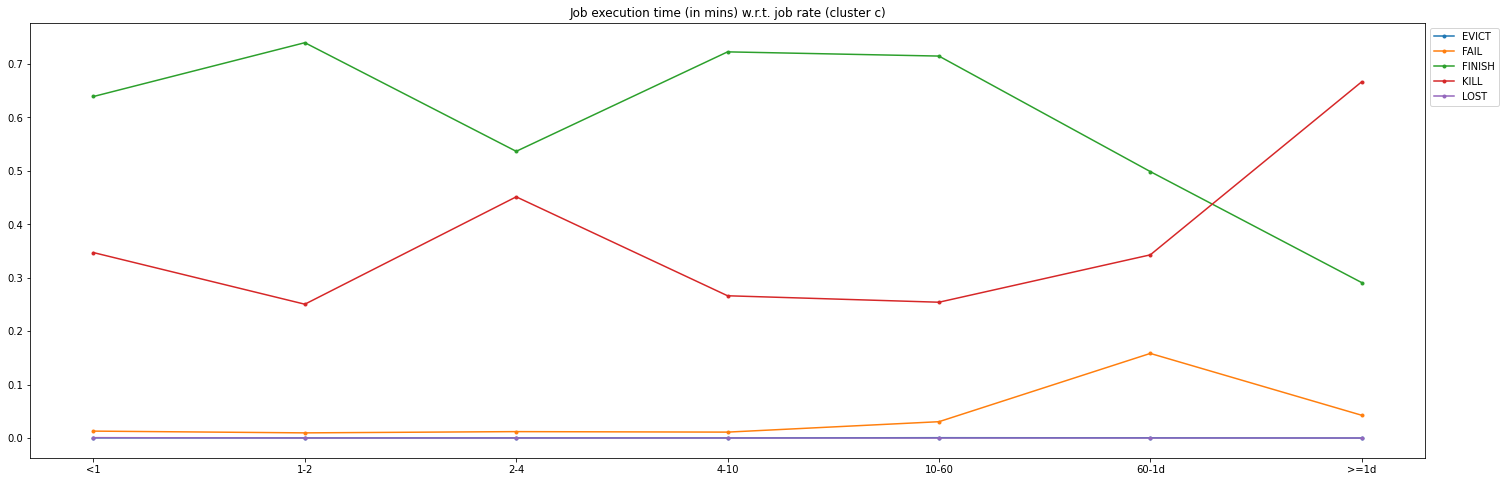

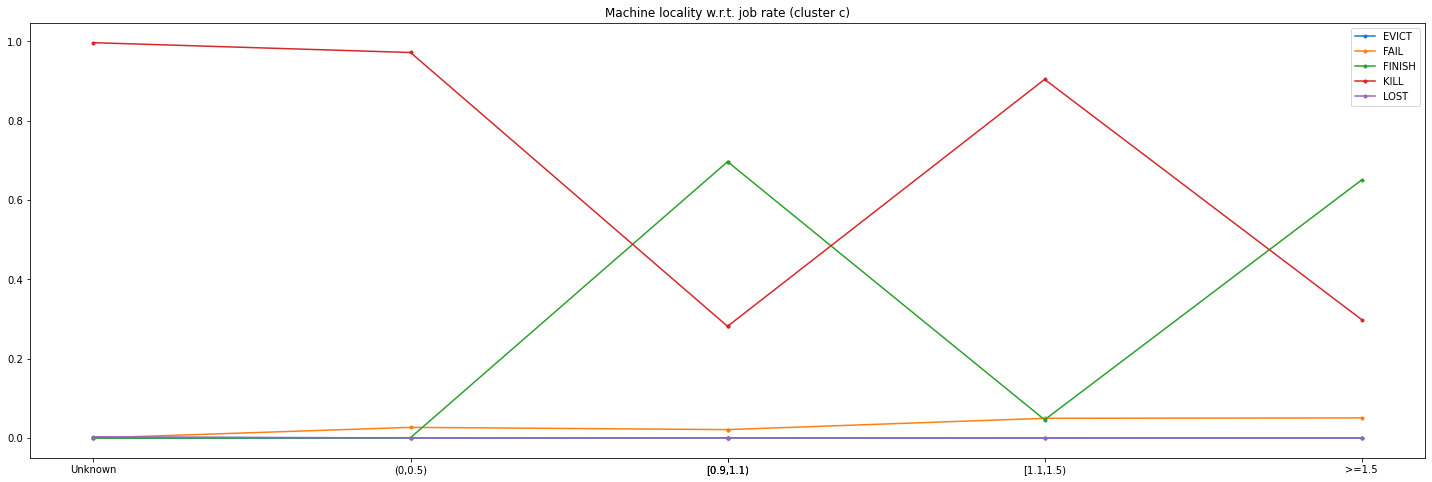

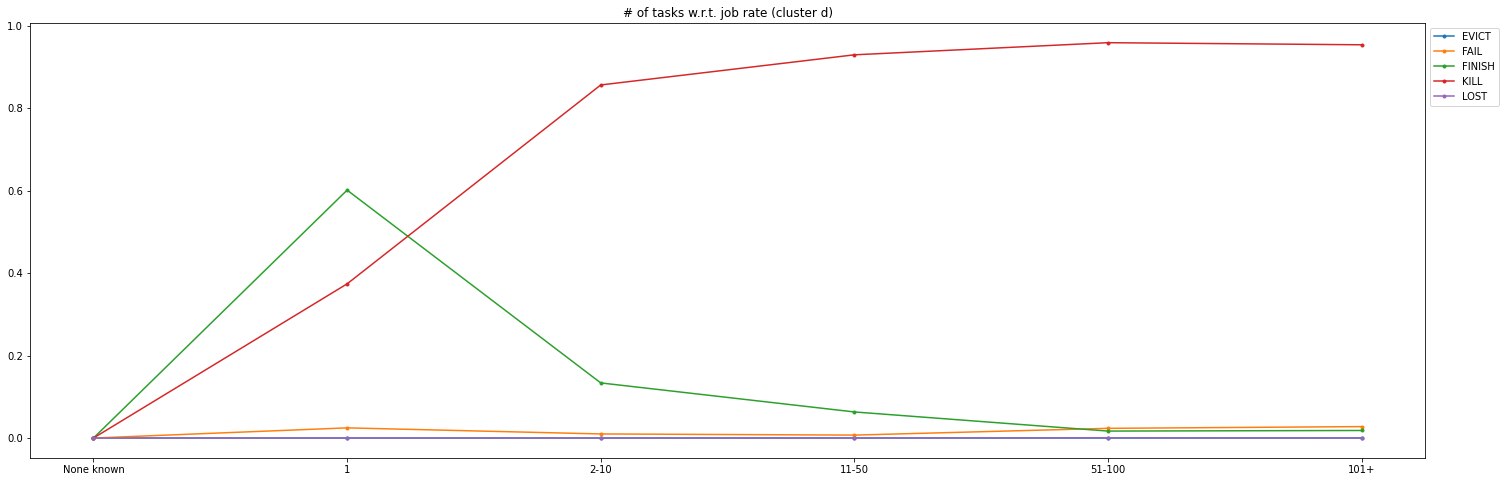

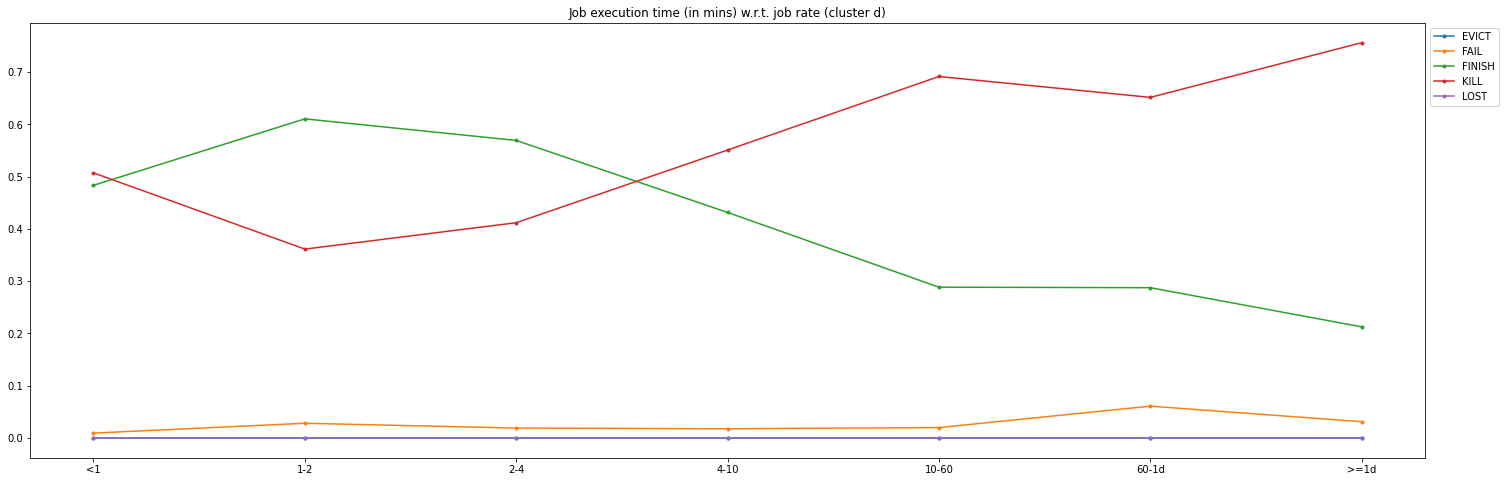

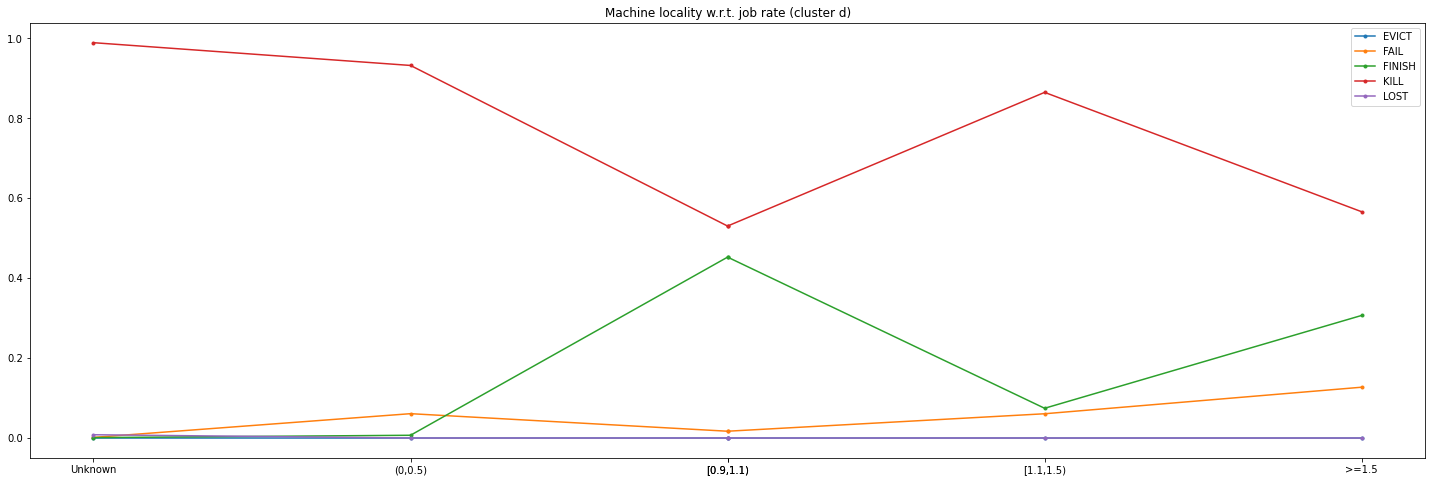

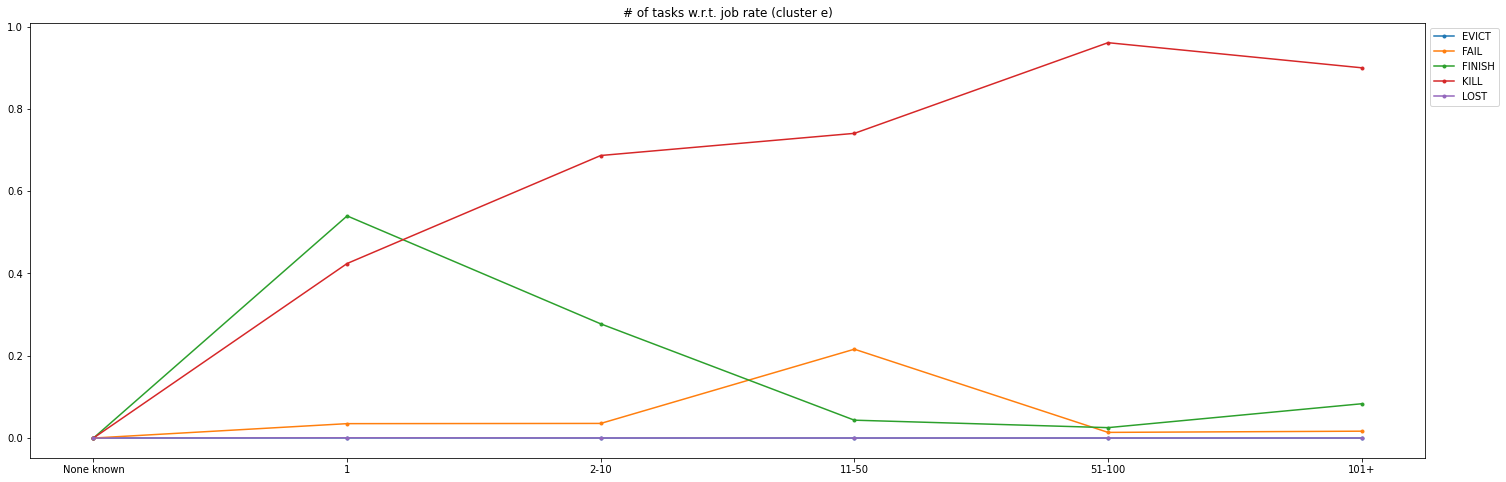

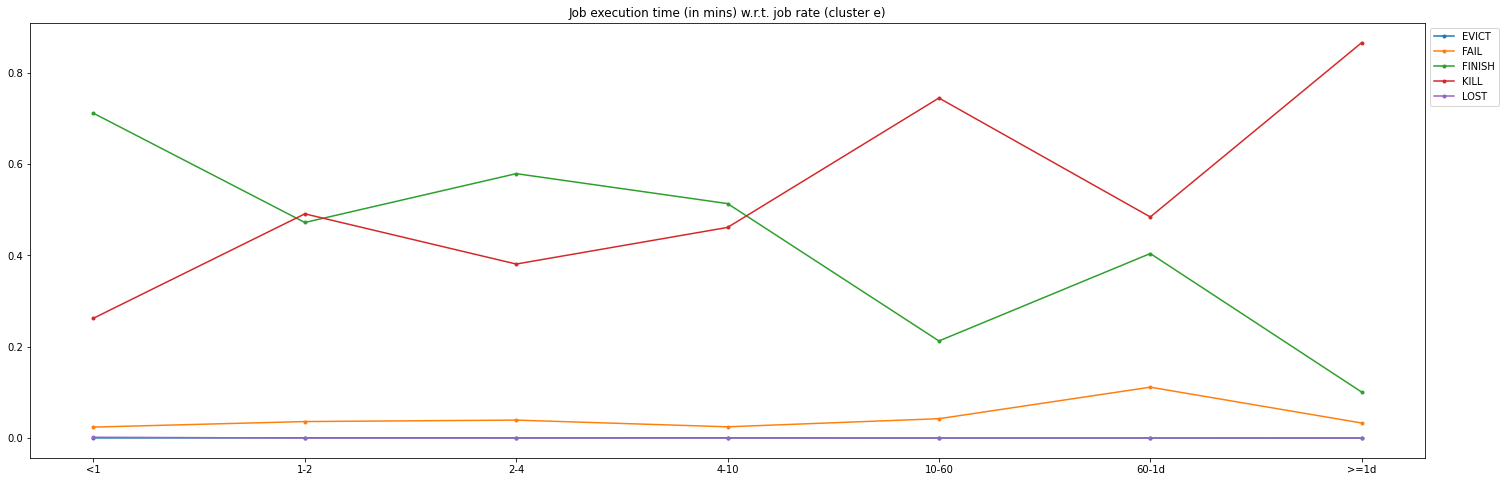

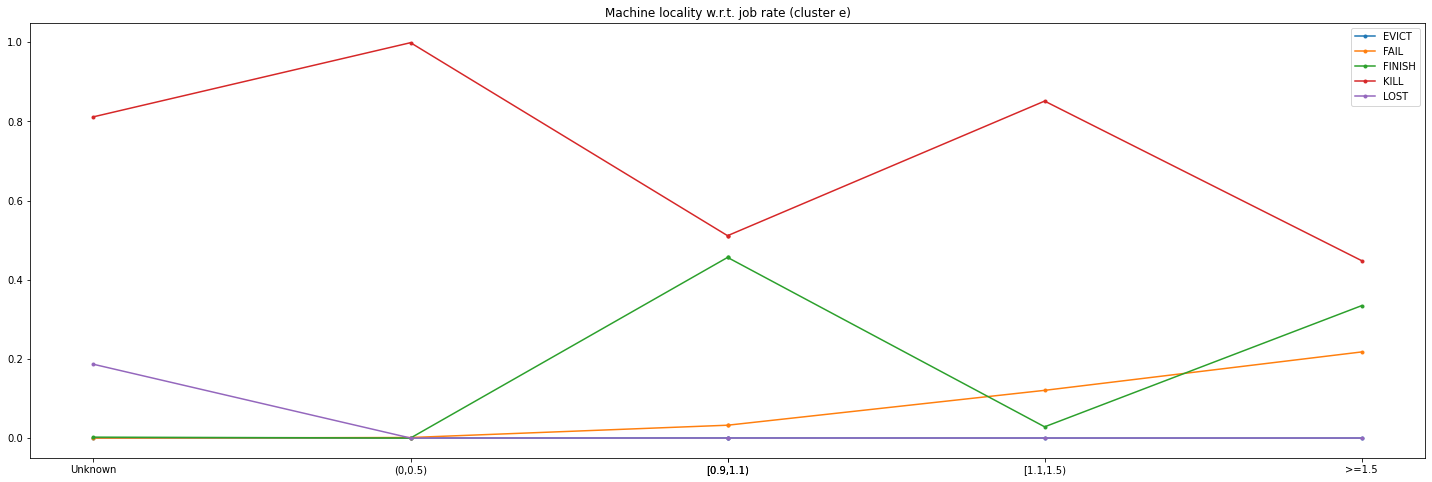

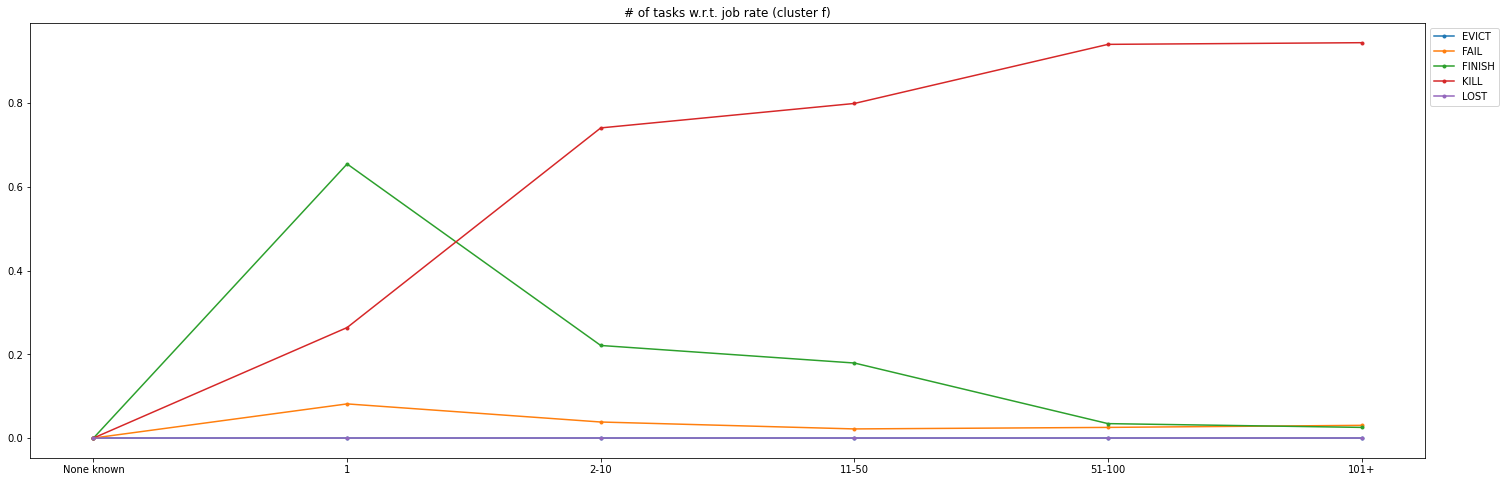

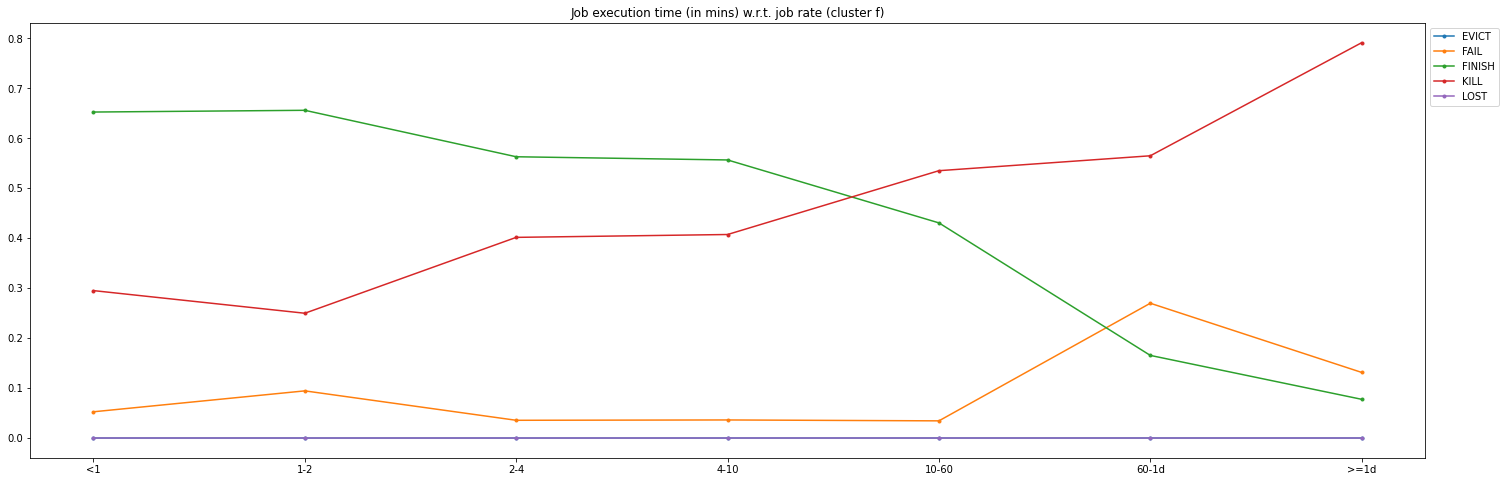

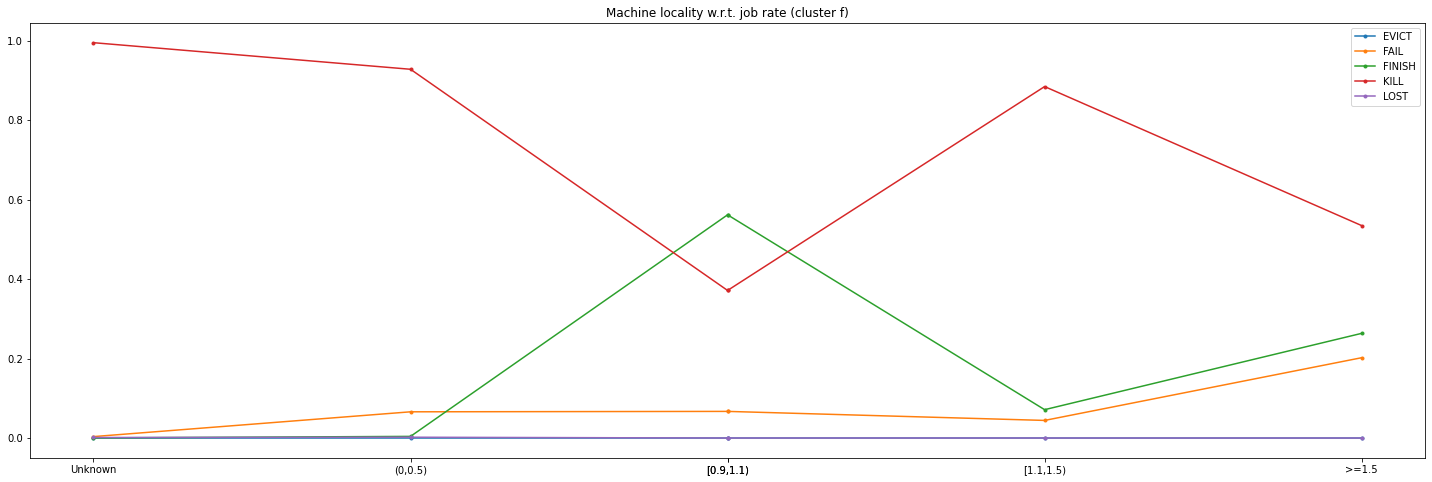

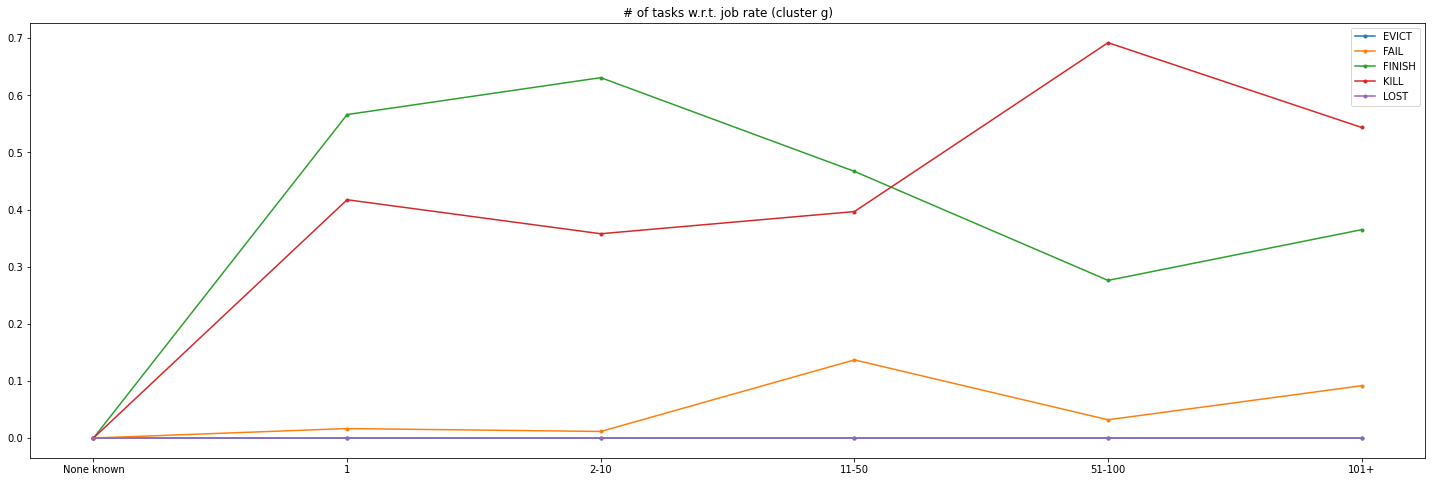

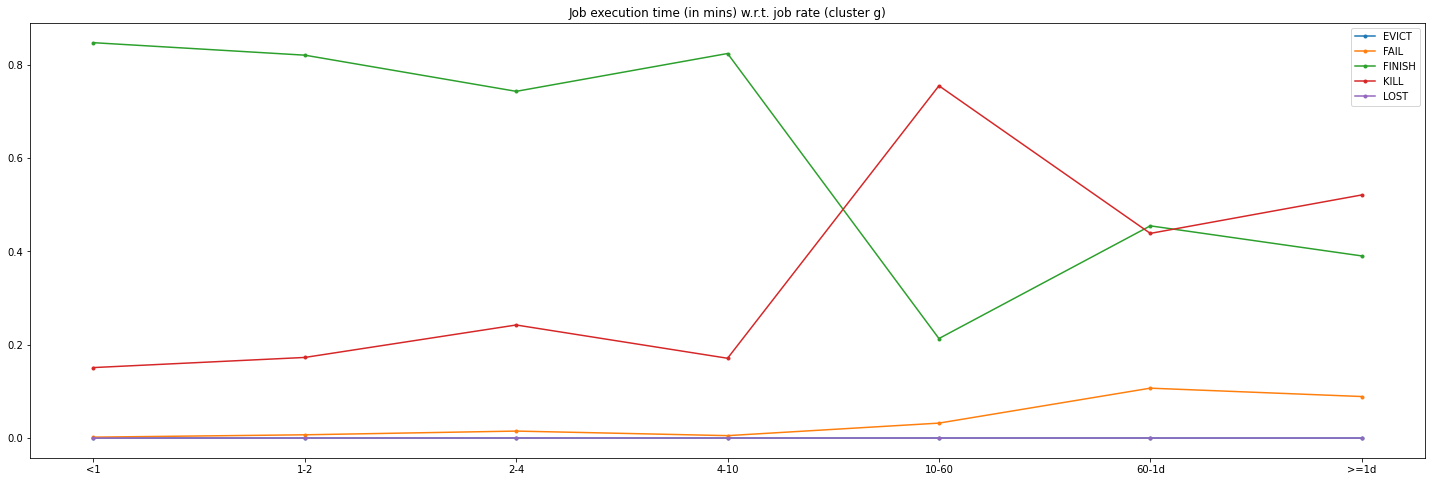

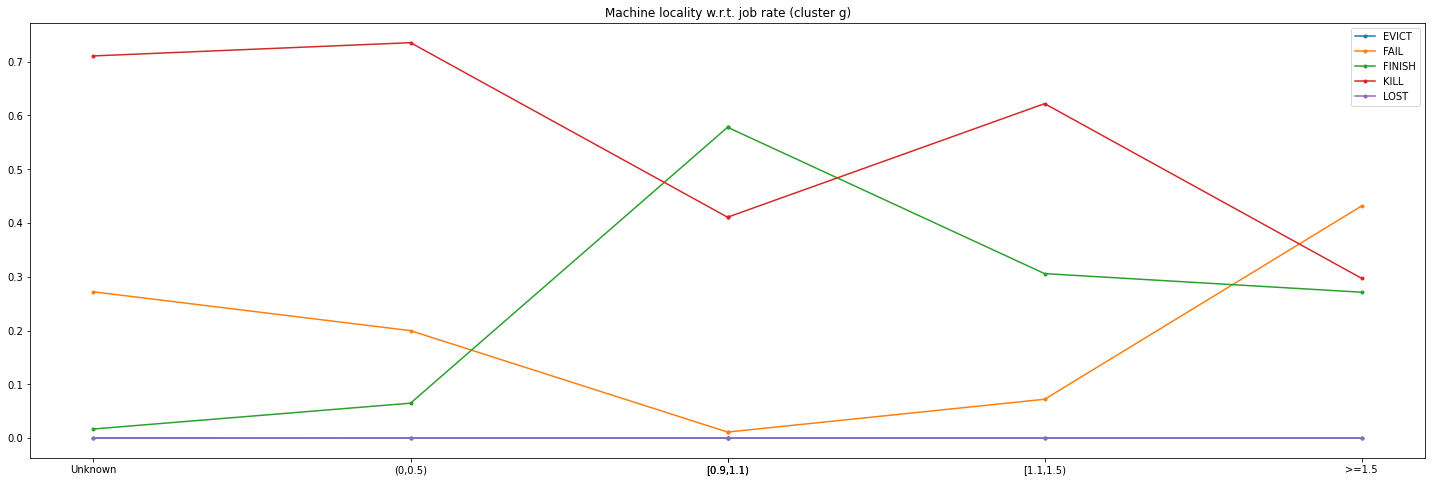

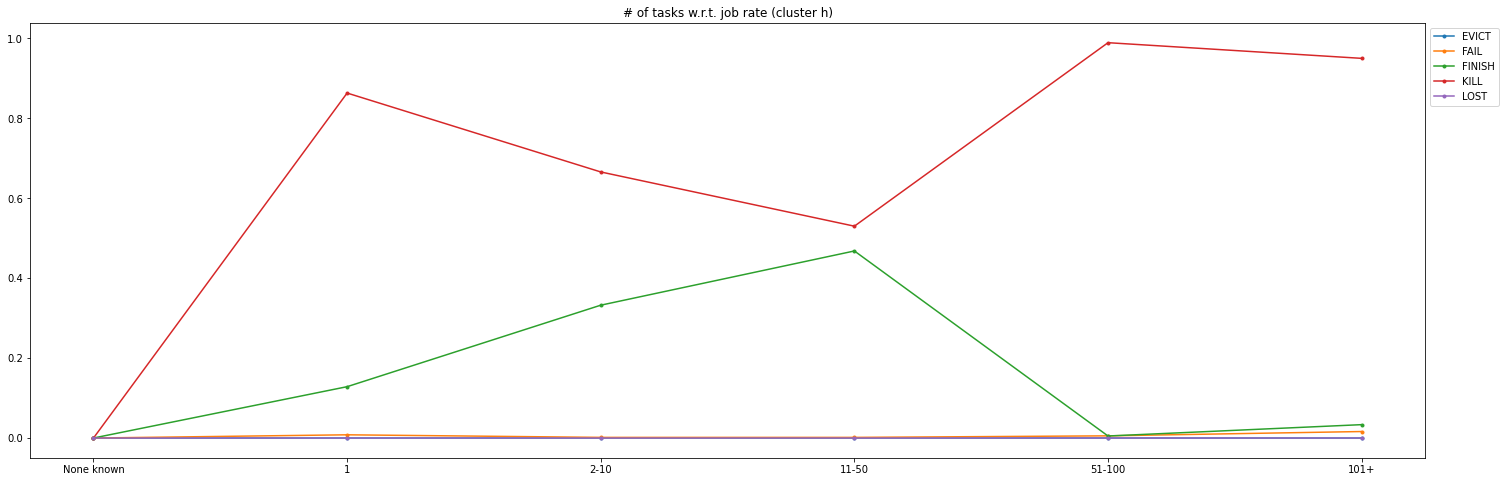

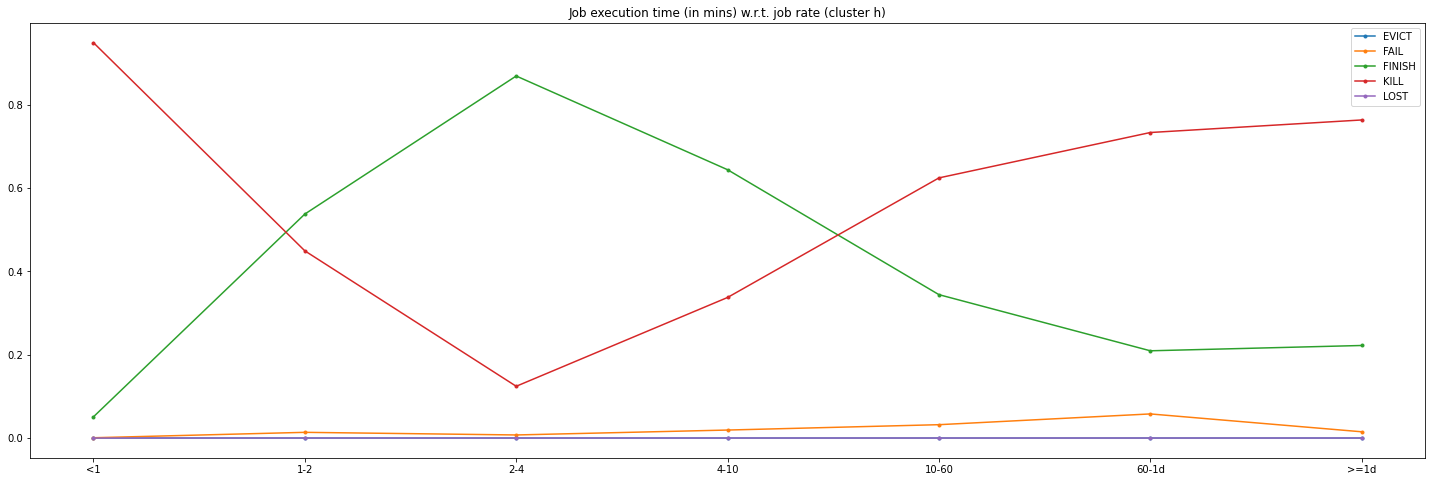

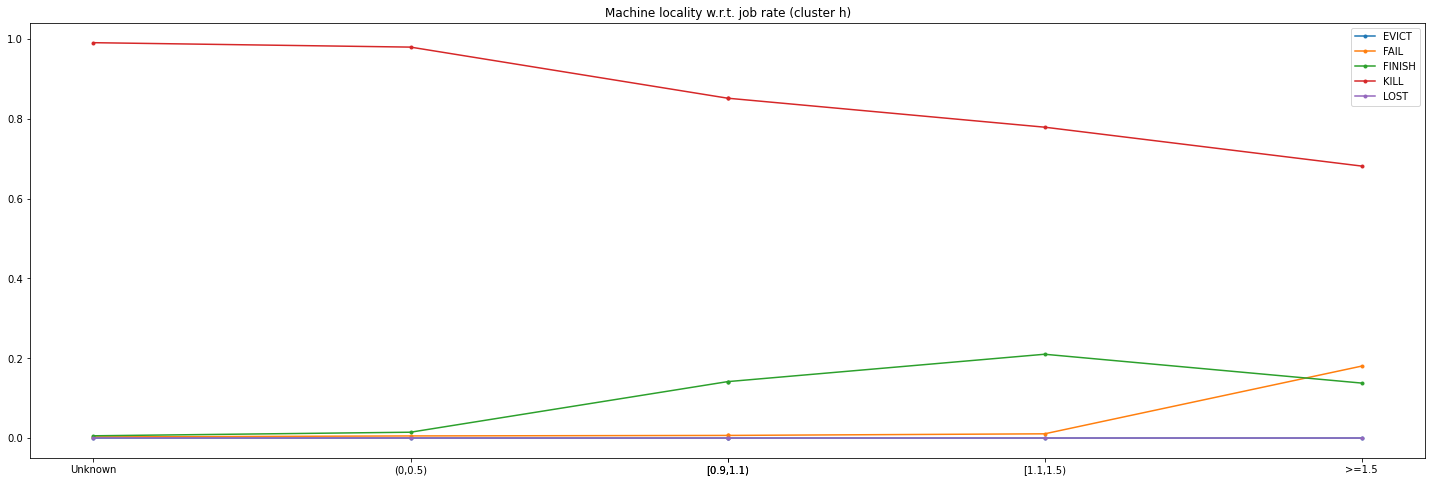

In [27]:
def to_9a_bin(col):
    # 1 [2,10] [11,50] [51,100] 101+
    if col <= 0:
        return "None known"
    elif col == 1:
        return "1"
    elif col <= 10:
        return "2-10"
    elif col <= 50:
        return "11-50"
    elif col <= 100:
        return "51-100"
    else:
        return "101+"
    
def to_9c_bin(col):
    # 1 [2,10] [11,50] [51,100] 101+
    if col <= 0:
        return "Unknown"
    elif col < 0.5:
        return "(0,0.5)"
    elif col < 0.9:
        return "[0.5,0.9)"
    elif col < 1.1:
        return "[0.9,1.1)"
    elif col < 1.5:
        return "[1.1,1.5)"
    else:
        return ">=1.5"

for cluster in "abcdefgh":
    dfa = pd.read_csv(DIR + cluster + "_term_task_count.csv") \
        .sort_values(["term", "task_count"])
    dfa["task_count"] = dfa["task_count"].apply(to_9a_bin)
    dfa = dfa.groupby(["term", "task_count"]).sum().reset_index()
    
    categorical_plot(dfa, "task_count", "# of tasks w.r.t. job rate (cluster " + 
                     cluster + ")", [to_9a_bin(x) for x in [-1,1,10,50,100,101]])
    
    # column should be called machine_count here, typo in analysis scripts
    dfb = pd.read_csv(DIR + cluster + "_priority_exectime/part-00000", header=None,
                names=["term", "priority", "interval", "count"]).sort_values(["term", "interval"])
    del dfb["priority"]
    dfb = dfb.groupby(["term", "interval"]).sum().reset_index()
   
    xs = ["<1", "1-2", "2-4", "4-10", "10-60", "60-1d", ">=1d"]
    categorical_plot(dfb, "interval", "Job execution time (in mins) w.r.t. job rate (cluster " + 
                     cluster + ")", xs)
      
    dfc = pd.read_csv(DIR + cluster + "_term_machine_locality.csv") \
        .sort_values(["term", "machine_locality"])
    dfc["machine_locality"] = dfc["machine_locality"].apply(to_9c_bin)
    dfc = dfc.groupby(["term", "machine_locality"]).sum().reset_index()
    
    categorical_plot(dfc, "machine_locality", "Machine locality w.r.t. job rate (cluster " + 
                     cluster + ")", [to_9c_bin(x) for x in [-1,0.49,0.99,1.09,1.49,1.5]])